In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import math
from datetime import datetime
from zoneinfo import ZoneInfo
import matplotlib.dates as mdates
from zoneinfo import ZoneInfo

plt.rcParams.update({'font.size': 14}) # Set global font size to 18
plt.rcParams["figure.figsize"] = (10, 6) 

SAMPLING_PERIOD = 50 * 10**(-3)
TRANSMISSION_RATIO = 8.89
WHEEL_RADIUS = 20.5 * 2.54 / 2 / 100
PI = 3.1415
MS_TO_KPH = 3.6
SHUNT_OFFSET = 45
ACCEL_SENSITIVITY_FACTOR = 0.122 / 1000

dataset_path = "./data/dados_telemetria/teste_odonto_08122025/teste7_longer"

driver_inputs = pd.read_csv(f'{dataset_path}/76_DRIVER_INPUTS.csv')
ecu_mode = pd.read_csv(f'{dataset_path}/77_ECU_MODE.csv')
torque_reference = pd.read_csv(f'{dataset_path}/78_TORQUE_REFERENCE.csv')
wheel_speed = pd.read_csv(f'{dataset_path}/79_WHEEL_SPEED.csv')
motor_speed = pd.read_csv(f'{dataset_path}/80_MOTOR_SPEED.csv')
left_motor_tractive = pd.read_csv(f'{dataset_path}/85_LEFT_MOTOR_TRACTIVE.csv')
right_motor_tractive = pd.read_csv(f'{dataset_path}/95_RIGHT_MOTOR_TRACTIVE.csv')
accelerometer = pd.read_csv(f'{dataset_path}/259_ACCELEROMETER.csv')
gyroscope = pd.read_csv(f'{dataset_path}/260_GYROSCOPE.csv')
eletrobuild_temperature = pd.read_csv(f'{dataset_path}/261_ELETROBUILD_TEMPERATURE.csv')
stack_1_voltage = pd.read_csv(f'{dataset_path}/300_STACK_1_VOLTAGE.csv')
stack_2_voltage = pd.read_csv(f'{dataset_path}/301_STACK_2_VOLTAGE.csv')
stack_3_voltage = pd.read_csv(f'{dataset_path}/302_STACK_3_VOLTAGE.csv')
stack_4_voltage = pd.read_csv(f'{dataset_path}/303_STACK_4_VOLTAGE.csv')
stack_5_voltage = pd.read_csv(f'{dataset_path}/304_STACK_5_VOLTAGE.csv')
stack_6_voltage = pd.read_csv(f'{dataset_path}/305_STACK_6_VOLTAGE.csv')
accumulador_params = pd.read_csv(f'{dataset_path}/306_ACCUMULADOR_PARAMS.csv')
bms_params = pd.read_csv(f'{dataset_path}/307_BMS_PARAMS.csv')
bms_error_flags = pd.read_csv(f'{dataset_path}/308_BMS_ERROR_FLAGS.csv')

In [55]:
def convert_rpm_to_velocity(rpm):
    return rpm / TRANSMISSION_RATIO * WHEEL_RADIUS * 2 * PI / 60 * MS_TO_KPH

def get_range_by_time(timestamps, start_date, end_date):
    if end_date == -1 or start_date == -1:
        return range(len(timestamps))
    
    start_timestamp = start_date.timestamp() * 1000
    end_timestamp = end_date.timestamp() * 1000

    start_idx = -1
    for index, value in enumerate(timestamps):
        if value > start_timestamp:
            start_idx = index
            break

    if start_idx == -1: start_idx = 0

    end_idx = -1
    for index, value in enumerate(timestamps):
        if value > end_timestamp:
            end_idx = index
            break

    if end_idx == -1: end_idx = len(timestamps) - 1

    return range(start_idx, end_idx)

In [56]:
accumulador_params.head(5)

,index,date,MAX_VOLTAGE,MIN_VOLTAGE,TOTAL_VOLTAGE,SHUNT_VOLTAGE,1,2,3,4
0,0,1765223565645,3.30,2.87,76.9,105,0,0,0,0
1,1,1765223565829,3.30,3.02,77.5,88,0,0,0,0
2,2,1765223567461,3.31,3.25,78.8,45,0,0,0,0
3,3,1765223569143,3.31,3.21,78.6,56,0,0,0,0
4,4,1765223570661,3.31,3.22,78.6,55,0,0,0,0


In [57]:
START_DATE = datetime(2025, 12, 8, 17, 10, 40, tzinfo=ZoneInfo("America/Sao_Paulo"))
END_DATE = datetime(2025, 12, 8, 17, 11, 5, tzinfo=ZoneInfo("America/Sao_Paulo"))
# END_DATE = -1

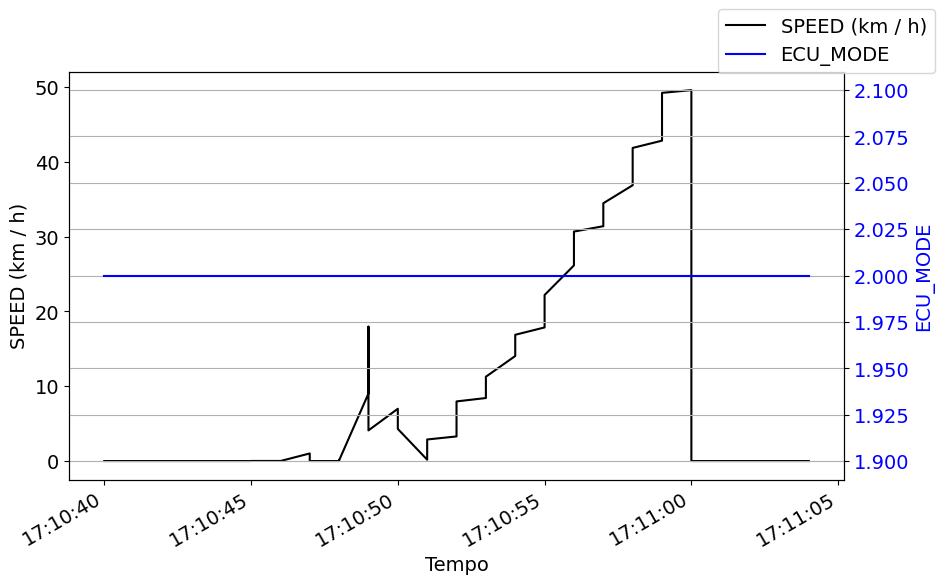

In [58]:
# car_velocity = (convert_rpm_to_velocity(right_motor_tractive['SPEED']) + convert_rpm_to_velocity(left_motor_tractive['SPEED'])) / 2
car_velocity = convert_rpm_to_velocity(left_motor_tractive['SPEED'])
mode = ecu_mode['MODE_ID'] 

range_velocity = get_range_by_time(
    left_motor_tractive['date'], 
    START_DATE, 
    END_DATE
)
range_mode = get_range_by_time(
    ecu_mode['date'], 
    START_DATE,
    END_DATE
)

timestamp_velocity = left_motor_tractive['date'][range_velocity] // 1000
timestamp_mode = ecu_mode['date'][range_mode] // 1000

# remove ruidos
car_velocity[abs(car_velocity) > 50] = 0
mode[abs(mode) > 5] = 0

# Convert Unix timestamps to datetime objects
dates_velocity = [datetime.fromtimestamp(ts) for ts in timestamp_velocity]
dates_mode = [datetime.fromtimestamp(ts) for ts in timestamp_mode]

# Create the plot
fig, ax1 = plt.subplots()
ax1.plot(dates_velocity, car_velocity[range_velocity], color="black", label="SPEED (km / h)")
ax1.set_xlabel('Tempo')
ax1.set_ylabel('SPEED (km / h)', color='black')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

ax2.plot(dates_mode, mode[range_mode], color="blue", label="ECU_MODE")
ax2.set_ylabel('ECU_MODE', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

date_format = mdates.DateFormatter('%H:%M:%S')
ax1.xaxis.set_major_formatter(date_format)

# Optional: Rotate x-axis labels for better readability if they overlap
fig.autofmt_xdate()

# Optional: align legends
fig.legend(loc='upper right')
plt.grid(True)
plt.show()

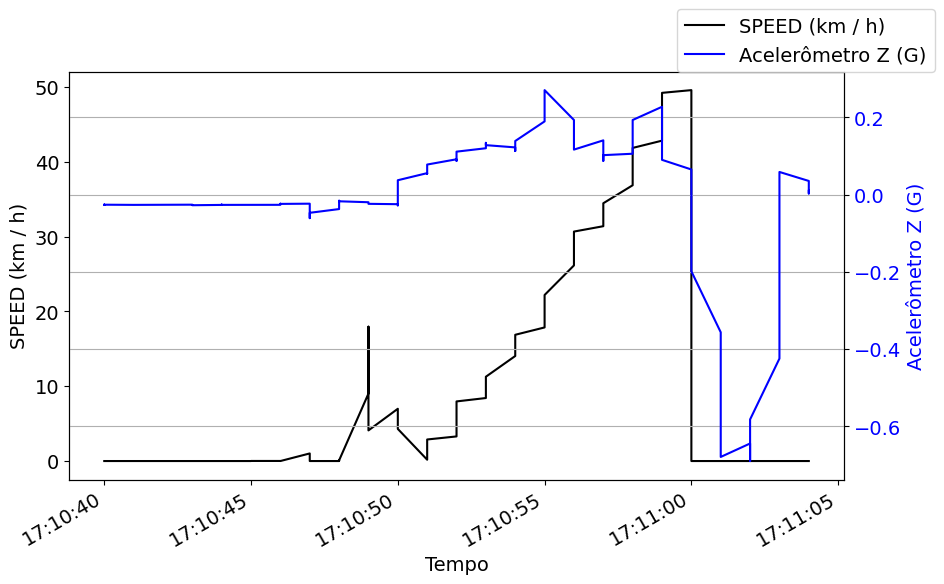

In [59]:
# car_velocity = (convert_rpm_to_velocity(right_motor_tractive['SPEED']) + convert_rpm_to_velocity(left_motor_tractive['SPEED'])) / 2
car_velocity = convert_rpm_to_velocity(left_motor_tractive['SPEED'])
current = accumulador_params['SHUNT_VOLTAGE'] - SHUNT_OFFSET 
accel = accelerometer['ACCEL_Z'] * ACCEL_SENSITIVITY_FACTOR
accel_media_movel = sma = accel.rolling(window=5).mean()

range_velocity = get_range_by_time(
    left_motor_tractive['date'], 
    START_DATE, 
    END_DATE
)
range_accel = get_range_by_time(
    accelerometer['date'], 
    START_DATE,
    END_DATE
)

timestamp_velocity = left_motor_tractive['date'][range_velocity] // 1000
timestamp_accel = accelerometer['date'][range_accel] // 1000

# remove ruidos
car_velocity[abs(car_velocity) > 50] = 0
current[abs(current) > 500] = 0

# Convert Unix timestamps to datetime objects
dates_velocity = [datetime.fromtimestamp(ts) for ts in timestamp_velocity]
dates_accel = [datetime.fromtimestamp(ts) for ts in timestamp_accel]

# Create the plot
fig, ax1 = plt.subplots()
ax1.plot(dates_velocity, car_velocity[range_velocity], color="black", label="SPEED (km / h)")
ax1.set_xlabel('Tempo')
ax1.set_ylabel('SPEED (km / h)', color='black')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

ax2.plot(dates_accel, accel_media_movel[range_accel], color="blue", label="Acelerômetro Z (G)")
ax2.set_ylabel('Acelerômetro Z (G)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

date_format = mdates.DateFormatter('%H:%M:%S')
ax1.xaxis.set_major_formatter(date_format)

# Optional: Rotate x-axis labels for better readability if they overlap
fig.autofmt_xdate()

# Optional: align legends
fig.legend(loc='upper right')
plt.grid(True)
plt.show()

317.0


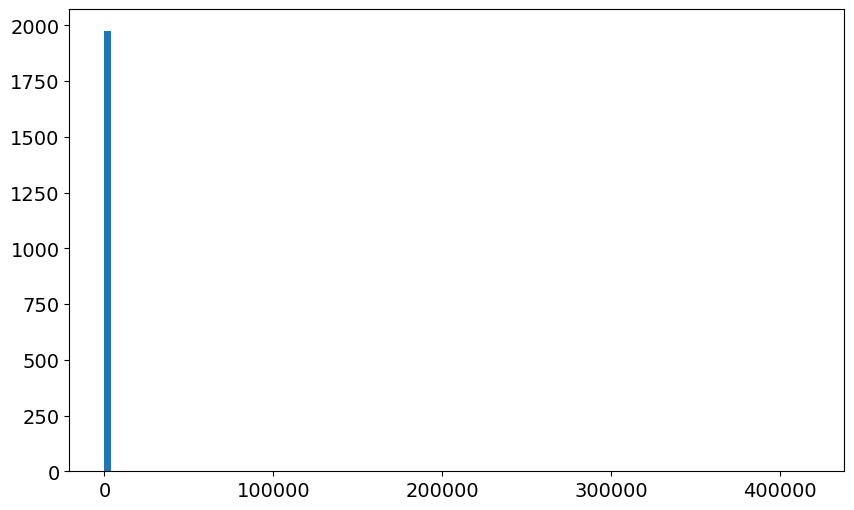

In [60]:
# analise de intervalos de shunt
time_intervals = []
for i in range(1, len(current)):
    time_intervals.append(ecu_mode['date'][i] - ecu_mode['date'][i - 1])


plt.hist(time_intervals, bins = 100)

print(np.median(time_intervals))

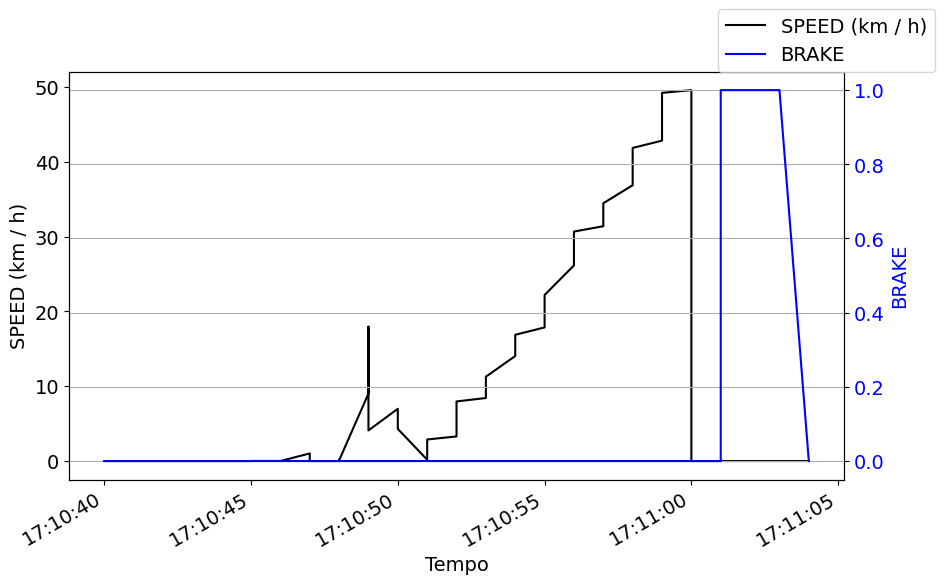

In [61]:
# analise dos freios
# car_velocity = (convert_rpm_to_velocity(right_motor_tractive['SPEED']) + convert_rpm_to_velocity(left_motor_tractive['SPEED'])) / 2
car_velocity = convert_rpm_to_velocity(left_motor_tractive['SPEED'])
brake = driver_inputs['BRAKE'] 

range_velocity = get_range_by_time(
    left_motor_tractive['date'], 
    START_DATE, 
    END_DATE
)
range_brake = get_range_by_time(
    driver_inputs['date'], 
    START_DATE,
    END_DATE
)

timestamp_velocity = left_motor_tractive['date'][range_velocity] // 1000
timestamp_brake = driver_inputs['date'][range_brake] // 1000

# remove ruidos
car_velocity[abs(car_velocity) > 50] = 0
brake[abs(brake) > 5] = 0

# Convert Unix timestamps to datetime objects
dates_velocity = [datetime.fromtimestamp(ts) for ts in timestamp_velocity]
dates_brake = [datetime.fromtimestamp(ts) for ts in timestamp_brake]

# Create the plot
fig, ax1 = plt.subplots()
ax1.plot(dates_velocity, car_velocity[range_velocity], color="black", label="SPEED (km / h)")
ax1.set_xlabel('Tempo')
ax1.set_ylabel('SPEED (km / h)', color='black')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

ax2.plot(dates_brake, brake[range_brake], color="blue", label="BRAKE")
ax2.set_ylabel('BRAKE', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

date_format = mdates.DateFormatter('%H:%M:%S')
ax1.xaxis.set_major_formatter(date_format)

# Optional: Rotate x-axis labels for better readability if they overlap
fig.autofmt_xdate()

# Optional: align legends
fig.legend(loc='upper right')
plt.grid(True)
plt.show()